## <center> Creating data source for exploratory data analysis (EDA) and modeling

This notebook will combine multiple data sources to produce EDA and model the outcome variables. The following are the data sources used in this notebook:

|Data Source | Description|
|:---|:---|
|[College Scorecard](https://data.ed.gov/dataset/college-scorecard-all-data-files)|  A data set produced by the U.S. Department of Education with facts about higher education institutions including graduation rates, median earnings post graduation, total student enrollment, and more.|
|[Integrated Post Secondary Database System](https://nces.ed.gov/ipeds/datacenter/DataFiles.aspx?year=-1)| A database of higher education institution and student attributes.|
|[Higher Education Research and Development (HERD) expenditures survey](https://www.nsf.gov/statistics/srvyherd/)| A dataset of research and development expenditures conducted by the National Science Foundation annually|
|[Niche](https://www.niche.com/colleges/search/best-colleges/)| A website containing higher education institution facts and other attributes.|

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import sqlite3

This notebook will combine multiple data sources into one final data set that will be used for EDA and modeling. The following steps are used in the process:
* Ingest the College Scorecard post graduation wages data for the 2008-2009 academic year measured in 2014-2015
* As a first alternative to missing data imputation, substitute missing data with previous years' data from the College Scorecard.

Ingest the 2014-2015 earnings data and merge with the institutional characteristics from academic year 2008-2009.

In [2]:
cs_1415 = pd.read_csv('./data/MERGED2014_15_PP.csv',usecols=['UNITID','MD_EARN_WNE_P6'])
cs_1415.columns = cs_1415.columns.str.lower()
cs_1415.head(3)

,unitid,md_earn_wne_p6
0,100654,25200
1,100663,35100
2,100690,30700


In [3]:
cs_0809 = pd.read_csv('./data/MERGED2008_09_PP.csv',low_memory=False)
cs_0809.columns = cs_0809.columns.str.lower()
cs_0809.drop('md_earn_wne_p6',axis=1,inplace=True)
cs_0809.head(3)

,unitid,opeid,opeid6,instnm,city,stabbr,zip,accredagency,insturl,npcurl,...,count_wne_male1_p8,md_earn_wne_male1_p8,gt_threshold_p10,md_earn_wne_inc1_p10,md_earn_wne_inc2_p10,md_earn_wne_inc3_p10,md_earn_wne_indep1_p10,md_earn_wne_indep0_p10,md_earn_wne_male0_p10,md_earn_wne_male1_p10
0,100636,01230800,12308,Community College of the Air Force,Montgomery,AL,36114-3011,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100654,00100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100663,00105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After merging both dataframes, the dataset has over 6,000 rows and close to 3,000 columns.

In [4]:
df = cs_1415.merge(cs_0809, how = 'left', on = 'unitid', indicator = True)
df = df[df['_merge'] == 'both'].drop('_merge',axis=1)
df.shape

(6177, 2989)

Some features have a very high number of missing observations. Use the last year or previous to last year's data from the College Scorecard to substitute missing data with previous years' data to reduce the degree of missingness in the data.

In [5]:
df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False).head(5)

md_earn_wne_male1_p10       6177
bbrr1_fed_ugunk_makeprog    6177
dbrr1_pp_ugcomp_rt          6177
dbrr1_pp_ugnocomp_n         6177
dbrr1_pp_ugnocomp_num       6177
dtype: int64

In [6]:
df.isnull().sum().sum()

10151291

Update the data for academic year 2008-2009 with the data from academic year 2007-2008 for features with missing data in academic year 2008-2009. This approach reduces the number of missing values to 9,764,805 across all features and institutions.

In [7]:
ly_data = pd.read_csv('./data/MERGED2007_08_PP.csv', low_memory=False)
ly_data.columns = ly_data.columns.str.lower()
ly_data.columns = [col+'_0708' for col in ly_data.columns]
ly_data.rename(columns={'unitid_0708':'unitid'}, inplace = True)
    
df = df.merge(ly_data, how = 'left', on = 'unitid')
    
for col in df.columns:
    if col != 'unitid' and '_0708' not in col:
        df[col].fillna(value=df[col+'_0708'],inplace=True)
        
df.drop(columns=[col for col in df.columns if '_0708' in col], inplace = True)  

In [8]:
df.isnull().sum().sum()

9764805

### Apply filters to the College Scorecard data
To make the institutions comparable within a heterogenous universe of institutions, apply the following filters:
* Remove institutions located in U.S. territories
* Remove institutions that do not award degrees
* Remove institutions that do not award a Bachelor's or Graduate degree
* Remove institutions that are highly specialized in only one field or whose missions may not be aligned with maximizing median earnings post graduation (i.e., Theological seminaries, Bible colleges, and other faith-related institutions)

In [9]:
territories = ['AS','FM','GU','MH','MP','PR','PW','VI']
df = df[~df.stabbr.isin(territories)]

In [10]:
df = df[df.highdeg > 2]

Add data of Carnegie Classification of Higher Education Institutions to classify universities by type (i.e., Theological seminaries, Bible colleges, and other faith-related institutions and Medical schools and medical centers, etc.)

In [11]:
df.drop(['ccbasic','latitude'], axis = 1, inplace = True)

hd2009 = pd.read_csv('./data/hd2009.csv',encoding='cp1252',
                   usecols=['unitid','latitude','longitud','ccbasic'])
hd2009.columns = hd2009.columns.str.lower()
hd2009.head(2)

df = df.merge(hd2009, how = 'left', on = 'unitid')

Remove from the data set any institutions that belong to the following Carnegie Classifications or that awarded 50% or more of its degrees in religious professions:
* Theological seminaries, Bible colleges, and other faith-related institutions
* Medical schools and medical centers
* Other health professions schools
* Schools of engineering
* Other technology-related schools
* Schools of business and management
* Schools of art, music, and design
* Schools of law
* Other special-focus institutions
* Tribal Colleges

In [12]:
df = df[~df.ccbasic.isin([i for i in range(24,34)])]

In [13]:
df[(df['pcip39'] >= .5)][['instnm','pcip39']].head()

,instnm,pcip39
42,American Indian College Inc,0.6923
651,Barclay College,0.5882
1495,Tri-State Bible College,1.0000
1578,Clarks Summit University,0.9481
1609,Gratz College,1.0000


In [14]:
df = df[~(df['pcip39'] >= .5)]

In [15]:
df.shape

(1770, 2990)

After applying these filters, the data set contains information on 1,770 institutions and close to 3000 features.

Access data from the `HERD` survey for fiscal year 2010. Based on the [HERD questionnaire documentation](https://www.nsf.gov/statistics/srvyherd/surveys/srvyherd_2010.pdf) keep only the total value of research and development expenditures using the `row` and `question` columns. The data for fiscal year 2010 was used in place of the data from fiscal year 2009 because it contains the `UNITID` identifier, which serves as a crosswalk to the College Scorecard data.

In [16]:
herd_10 = pd.read_csv('./data/herd_2010.csv', encoding='cp1252', low_memory = False)
herd_10.columns = herd_10.columns.str.lower()
herd_10.head(3)

,inst_id,year,ncses_inst_id,ipeds_unitid,hbcu_flag,med_sch_flag,hhe_flag,toi_code,hdg_code,toc_code,...,inst_zip,questionnaire_no,question,row,column,data,status,othinfo,othinfo_s,standardized_agency_names
0,166,2010,U0626001,111966.0,0,T,1,1,2,2,...,90059,01.a,Source,Federal government,NaN,20430.0,NaN,NaN,NaN,NaN
1,166,2010,U0626001,111966.0,0,T,1,1,2,2,...,90059,01.e,Source,Institution funds,NaN,1722.0,NaN,NaN,NaN,NaN
2,166,2010,U0626001,111966.0,0,T,1,1,2,2,...,90059,01.g,Source,Total,NaN,22152.0,NaN,NaN,NaN,NaN


In [17]:
herd_10 = herd_10[(herd_10.row == 'Total') & (herd_10.question == 'Source')]
herd_10.head()

,inst_id,year,ncses_inst_id,ipeds_unitid,hbcu_flag,med_sch_flag,hhe_flag,toi_code,hdg_code,toc_code,...,inst_zip,questionnaire_no,question,row,column,data,status,othinfo,othinfo_s,standardized_agency_names
2,166,2010,U0626001,111966.0,0,T,1,1,2,2,...,90059,01.g,Source,Total,NaN,22152.0,NaN,NaN,NaN,NaN
100,1002,2010,U0047001,100654.0,1,F,0,1,1,1,...,35762,01.g,Source,Total,NaN,30497.0,NaN,NaN,NaN,NaN
365,1005,2010,U0049001,100724.0,1,F,0,1,1,1,...,36101,01.g,Source,Total,NaN,13340.0,NaN,NaN,NaN,NaN
421,1009,2010,U0323002,100858.0,0,F,0,1,1,1,...,36849,01.g,Source,Total,NaN,145115.0,NaN,NaN,NaN,NaN
1024,1020,2010,U1533001,101480.0,0,F,0,1,2,1,...,36265,01.g,Source,Total,NaN,398.0,NaN,NaN,NaN,NaN


In [18]:
herd_10.isnull().sum()[herd_10.isnull().sum()>0]

ncses_inst_id                  8
ipeds_unitid                  29
inst_zip                       1
column                       744
status                       729
othinfo                      744
othinfo_s                    744
standardized_agency_names    744
dtype: int64

Twenty-nine institutions do not have an `ipeds_unitid` or the common identifier needed to merge the data with the main data set. Using [College Navigator](https://nces.ed.gov/collegenavigator/), find the `ipeds_unitid's` for these institutions. Drop institutions whose `ipeds_unitid's` could not be found.

In [19]:
unitid_updates = {'Arizona State University':104151,
                  'Embry-Riddle Aeronautical University': 133553,
                  'Midwestern University (Downers Grove, IL)':143853,
                  'University of New Hampshire':183044,
                  'Oregon State University':209542,
                  'University of Connecticut':129020,
                  'Fairleigh Dickinson University':184603,
                  'Long Island University':192448,
                  'Bowling Green State University':201441,
                  'Kent State University':203517,
                  'Miami University':204024,
                  'Ohio State University':204796,
                  'Ohio University':204857,
                  'University of Cincinnati':201885,
                  'University of Oklahoma':207500,
                  'Wright State University':206604,
                  'University of Akron':200800,
                  'Johns Hopkins University':162928,
                  'Touro University-California':459736,
                  'University of Mississippi':176017,
                  'William & Mary':231624,
                  'Western Michigan University and Homer Stryker M.D. School of Medicine':490373,
                  'Oklahoma State University Tulsa':207315}

In [20]:
for key,value in unitid_updates.items():
    herd_10.loc[herd_10.inst_name_long == key,'ipeds_unitid'] = value

In [21]:
herd_10.dropna(subset=['ipeds_unitid'],inplace=True)
herd_10.rename(columns={'ipeds_unitid':'unitid', 'data':'rd_exp', 'inst_name_long':'institution_name'},
               inplace=True)

In [22]:
herd_10 = herd_10[['unitid','institution_name','rd_exp']]

In [23]:
df = df.merge(herd_10, how = 'left', on = 'unitid')

Ingest and merge data from IPEDS. These data include:
* Student-faculty ratios and total enrollment

In [24]:
ef2009d = pd.read_csv('./data/ef2009d.csv')
ef2009d.columns = ef2009d.columns.str.lower()

ef2009d.rename(columns={'stufacr ':'stufacr'}, inplace = True)

ef2009d = ef2009d[['unitid','stufacr']]

In [25]:
df = df.merge(ef2009d, how = 'left', on = 'unitid')

### Clean the resulting data set

Replace values of `PrivacySuppressed` with `NaN` and convert numeric type features to float type.

In [26]:
for col in [col for col in df.columns if df[col].dtypes == 'O']:
    df.loc[df[col]=='PrivacySuppressed', col] = np.nan
    
    try:
        df[col] = df[col].astype(float)
    except:
        pass

The features below are expected to be of string type. The data type conversion was performed successfully.

In [27]:
[col for col in df.columns if df[col].dtypes == 'O']

['opeid',
 'instnm',
 'city',
 'stabbr',
 'zip',
 'repay_dt_mdn',
 'separ_dt_mdn',
 'alias',
 'ciptitle1',
 'ciptitle2',
 'ciptitle3',
 'ciptitle4',
 'ciptitle5',
 'ciptitle6',
 'institution_name']

#### Merge the data set with additional attributes obtained through webscrapping

In [28]:
sqlite_db = './data/webscrapping_profile_feats.sqlite'
conn = sqlite3.connect(sqlite_db)

In [29]:
sql = """
SELECT *
FROM niche_webscrapping
"""

webscrapping = pd.read_sql(sql, con = conn)

In [30]:
df = df.merge(webscrapping, how = 'left', on = 'instnm', indicator = True)

Remove any institutions that do not have the median earnings and two-cohort default rate features. These cases represent aroudn 3% of all institutions.

In [31]:
df[df.md_earn_wne_p6.isnull()].shape[0]

47

In [32]:
df = df[~df.md_earn_wne_p6.isnull()]

The final data set includes 1,723 institutions and 1575 features. This number of institutions is comparable to the [U.S. News & World Report's](https://www.usnews.com/best-colleges/search) 1,870 ranked institutions in the Best Colleges ranking. This means that the 1723 institutions reflect a plausible universe of institutions to include in the analysis.

In [33]:
df.drop(columns=list(df.isnull().sum()[df.isnull().sum()==df.shape[0]].index),inplace=True)

In [34]:
df.shape

(1723, 1575)

In [35]:
df[['md_earn_wne_p6']].isnull().sum()

md_earn_wne_p6    0
dtype: int64

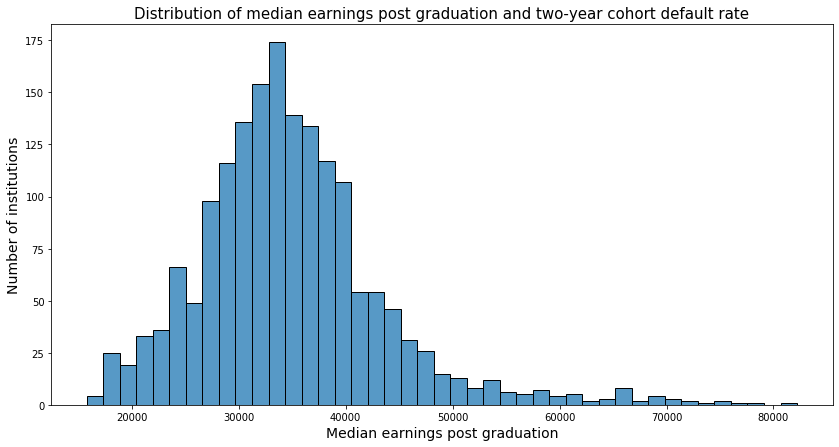

In [36]:
plt.figure(figsize = (14,7))
sns.histplot(data = df, x = 'md_earn_wne_p6')
plt.xlabel('Median earnings post graduation', fontsize = 14)
plt.ylabel('Number of institutions', fontsize = 14)

plt.title('Distribution of median earnings post graduation and two-year cohort default rate',size = 15);

There is a significant amount of variability in the median earnings post graduation. This feature appears to follow a roughly normal distribution with a long right tail, representing institutions with higher median earnings compared to the median and mean earnings values. There is enough variance in the data to make modeling these features a viable option.

The following features have a strong Pearson correlation with the median earnings feature (`md_earn_wne_p6`), signaling that the data set contains features that may serve as predictors of this target.

* Share of students earning over 25,000/year (threshold earnings)
* 90th percentile of earnings of students working and not enrolled 6 years after entry
* Dependent students with family incomes between 110,001+ in nominal dollars
* One-year repayment rate for dependent students
* Share of students who received a Pell Grant while in school
* Percent of students whose parents' highest educational level is high school
* Average family income in real 2015 dollars
* Midpoint of SAT scores at the institution (math)

In [37]:
df[['dep_rpy_1yr_rt','pell_ever','par_ed_pct_hs','faminc','satmtmid','md_earn_wne_p6']].corr()[['md_earn_wne_p6']]

,md_earn_wne_p6
dep_rpy_1yr_rt,0.690419
pell_ever,-0.665640
par_ed_pct_hs,-0.667113
faminc,0.610561
satmtmid,0.630571
md_earn_wne_p6,1.000000


There appears to be a moderate and negative relationship between the Niche ranking and median earnings. The higher the ranking (closer to 1, in the sense of a ranking), the higher the median earnings appear to be for some of the schools in the data set.

In [38]:
df['ranks'] = [str(rank).split(' ')[0].replace('#','') for rank in df.ranks]

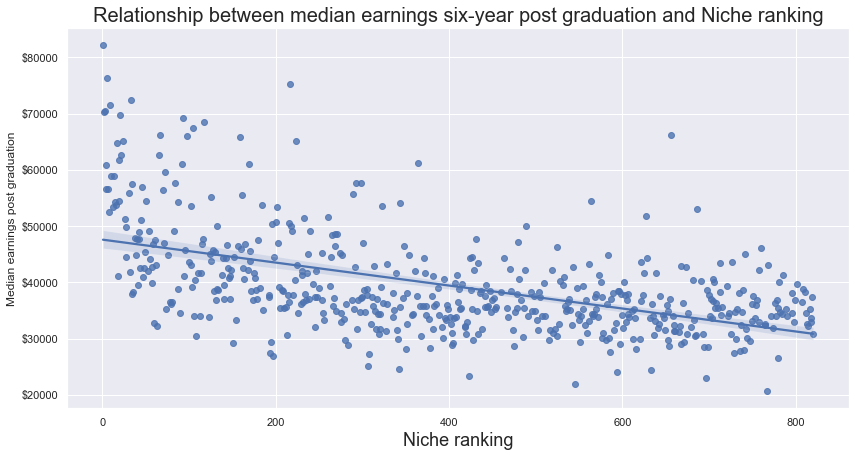

In [39]:
plt.figure(figsize=(14,7))
sns.set_theme()
plot = sns.regplot(x=df[df['ranks'] != 'nan']['ranks'].astype(int),y=df[df['ranks'] != 'nan']['md_earn_wne_p6'])
formatter = ticker.FormatStrFormatter('$%1.0f')
plot.yaxis.set_major_formatter(formatter)
plt.xlabel('Niche ranking', size=18)
plt.ylabel('Median earnings post graduation')
plt.title('Relationship between median earnings six-year post graduation and Niche ranking', size=20);

Through the EDA process, consider features used in the Niche ranking calculations, including:
* Admission rates
* Average loan amounts
* Student to faculty ratios

The following is a data dictionary of features contained in this data set that will be used in the EDA step:

| Feature Name | Description |
|:---|:---|
| gt_25k_p6 | Share of students earning over 25,000/year |
| pct90_earn_wne_p6 | 90th percentile of earnings of students working and not enrolled 6 years after entry |
| dep_inc_pct_h2 | Dependent students with family incomes between 110,001+ in nominal dollars |
| dep_rpy_1yr_rt | One-year repayment rate for dependent students |
| pell_ever | Share of students who received a Pell Grant while in school |
| par_ed_pct_hs | Percent of students whose parents' highest educational level is high school |
| faminc | Average family income in real 2015 dollars |
| satmtmid | Midpoint of SAT scores at the institution (math) |
| dep_inc_pct_lo | Percentage of students who are financially dependent and have family incomes between 0-30,000 |
| inc_pct_lo | Percentage of aided students whose family income is between 0-30,000 |
| ftftpctpell | Percentage of full-time, first-time degree/certificate-seeking undergraduate students awarded a Pell Grant |
| rpy_1yr_rt | Fraction of repayment cohort who are not in default, and with loan balances that have declined one year since entering repayment |
| md_earn_wne_p6 | Median earnings six years post graduation |
| cdr2 | Two-year cohort default rate |

Store the result in a database.

In [40]:
sqlite_db = './data/analysis_data_set.sqlite'
conn = sqlite3.connect(sqlite_db)

In [41]:
df.to_sql('analysis_data_set',
            con=conn,
            if_exists='replace',
            index=False)